# TDK dolgozat programkódja az operációs kockázatok becsléséről

A számolás során a poisson-lognormális modell módszertanát alkalmaztam, amely az AMA modellezés egyik lehetősége a működési kockázatokkal kapcsolatos tőkekövetelmény meghatározásához.


Szükséges bővítmények importálása:

In [1]:
import numpy as np
import statistics as stat
from scipy import stats as st
import pandas as pd
from pandas_profiling import ProfileReport as pp
import math as m

## Bevezetés:

Használt Függvények rogzítése:

In [2]:
#forrás: https://stackoverflow.com/questions/51740306/scipy-kstest-typeerror-parse-args-takes-from-3-to-5-positional-arguments-but

def get_best_distribution(data):
    dist_names = ["expon", "pareto", "lognorm"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

In [2]:
#Saját szerkesztés:
def oploss_montecarlo(lambda1, mu1, sigma1, correction, maincycle,subcycle):  
  yearly_losses=[]
  for cycle in range(maincycle):
    operating_loss = []
    lambdalist = np.random.poisson(lambda1, subcycle)
    for lambdas in lambdalist:
        num = sum(np.random.lognormal(mu1, sigma1, lambdas).tolist()) + lambdas*correction
        operating_loss.append(num)
    yearly_losses.append(np.percentile(np.array(operating_loss),99.9))
  capital = stat.mean(yearly_losses)
  return capital

In [88]:
cap = oploss_montecarlo(2,12.3,2.5,50000,100,40000)
cap

832562232.6375118

## Adatelemzés:

In [2]:
df = pd.read_excel('....../data.xlsx')
df["lossrounded"] = df["veszteség_teljes"].round()
df['group_1'] = df['Eseménytípus 1. szint'].astype(str).str[0]
df['group_2'] = df['Eseménytípus 2. szint'].astype(str).str[0]

df = df[df['lossrounded'] > 50000]
ln = []
for i in df["lossrounded"]:
    ln.append(m.log(i))
df["ln"] = ln

df["lossrounded-50k"] = df["lossrounded"]-50000
ln2=[]
for i in df["lossrounded-50k"]:
    ln2.append(m.log(i))
df["ln2"] = ln2

df.head()

,Azonosító,Eseménytípus 1. szint,Eseménytípus 2. szint,Eseménytípus 3. szint,Üzletág 1,év,veszteség_teljes,lossrounded,group_1,group_2,ln,lossrounded-50k,ln2
0,30000,2. Külső csalás,1. Lopás és csalás (külső),NaN,Lakossági bank tevékenység,2010,666821.1,666821.0,2,1,13.410277,616821.0,13.332334
1,30001,"7. Végrehajtás, teljesítés és folyamatkezelés","1. Tranzakció rögzítése, lebonyolítása és keze...",NaN,Lakossági közvetítői tevékenység,2010,137519.8,137520.0,7,1,11.831525,87520.0,11.379623
2,30002,"7. Végrehajtás, teljesítés és folyamatkezelés","1. Tranzakció rögzítése, lebonyolítása és keze...",NaN,Lakossági bank tevékenység,2009,85800.0,85800.0,7,1,11.359774,35800.0,10.485703
3,30004,2. Külső csalás,1. Lopás és csalás (külső),NaN,Lakossági bank tevékenység,2009,533137.0,533137.0,2,1,13.186534,483137.0,13.088056
4,30005,2. Külső csalás,1. Lopás és csalás (külső),NaN,Lakossági bank tevékenység,2010,112875.4,112875.0,2,1,11.634036,62875.0,11.048904


In [ ]:
profile = pp(df)
profile

In [12]:
get_best_distribution(df["ln"])

p value for expon = 3.4315834621090682e-90
p value for pareto = 2.52228723761856e-123
p value for lognorm = 0.0002699989133036274
Best fitting distribution: lognorm
Best p value: 0.0002699989133036274
Parameters for the best fit: (0.5841198450864463, 10.411247436524752, 1.8299388098201028)


('lognorm',
 0.0002699989133036274,
 (0.5841198450864463, 10.411247436524752, 1.8299388098201028))

In [15]:
get_best_distribution(df["ln2"])

p value for expon = 0.0
p value for pareto = 0.0


/Users/rajkal/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


p value for lognorm = 7.631911597097408e-06
Best fitting distribution: lognorm
Best p value: 7.631911597097408e-06
Parameters for the best fit: (0.14944905313783607, 1.0116970412208683, 10.998821355540544)


('lognorm',
 7.631911597097408e-06,
 (0.14944905313783607, 1.0116970412208683, 10.998821355540544))

## Tőke becslés eseménycsoportonként:

In [10]:
ev = int(max(df["év"])-min(df["év"]))+1
print((max(df["év"])-min(df["év"])+1), " az érték amelyel osztani kell majd a lambda értékek meghatározásához.")

13  az érték amelyel osztani kell majd a lambda értékek meghatározásához.


In [41]:
full_capital = 0

1 csoport:

In [42]:
event_type_1 = df[df['group_1']== "1"]
print("\u03BB=",len(event_type_1)/ev,
      " \u03BC=", stat.mean(event_type_1["ln2"]), "  \u03C3=", m.sqrt(stat.pvariance(event_type_1["ln2"])))

type_1_cap=oploss_montecarlo(len(event_type_1)/ev, stat.mean(event_type_1["ln2"]), m.sqrt(stat.pvariance(event_type_1["ln2"])),50000,100,100000)
full_capital += type_1_cap
type_1_cap

λ= 2.3846153846153846  μ= 14.417019660439184   σ= 2.483770618621262


7427359002.626592

2 csoport:

In [43]:
event_type_2 = df[df['group_1']== "2"]
print("\u03BB=",len(event_type_2)/ev,
      " \u03BC=", stat.mean(event_type_2["ln2"]), "  \u03C3=", m.sqrt(stat.pvariance(event_type_2["ln2"])))

type_2_cap=oploss_montecarlo(len(event_type_2)/ev, stat.mean(event_type_2["ln2"]), m.sqrt(stat.pvariance(event_type_2["ln2"])),50000,100,100000)
full_capital += type_2_cap
type_2_cap

λ= 182.46153846153845  μ= 11.83353233030263   σ= 1.4130994405547246


153343298.779297

3: csoport

In [44]:
event_type_3 = df[df['group_1']== "3"]
print("\u03BB=",len(event_type_3)/ev,
      " \u03BC=", stat.mean(event_type_3["ln2"]), "  \u03C3=", m.sqrt(stat.pvariance(event_type_3["ln2"])))

type_3_cap=oploss_montecarlo(len(event_type_3)/ev, stat.mean(event_type_3["ln2"]), m.sqrt(stat.pvariance(event_type_3["ln2"])),50000,100,100000)
full_capital += type_3_cap
type_3_cap

λ= 7.3076923076923075  μ= 13.335235065423712   σ= 2.4068459929237123


4016967017.691008

4. csoport:

In [45]:
event_type_4 = df[df['group_1']== "4"]
print("\u03BB=",len(event_type_4)/ev,
      " \u03BC=", stat.mean(event_type_4["ln2"]), "  \u03C3=", m.sqrt(stat.variance(event_type_4["ln2"])))

type_4_cap=oploss_montecarlo(len(event_type_4)/ev, stat.mean(event_type_4["ln2"]), m.sqrt(stat.pvariance(event_type_4["ln2"])),50000,100,100000)
full_capital += type_4_cap
type_4_cap

λ= 21.384615384615383  μ= 12.572951895077766   σ= 2.35749335386795


2908456061.6852875

5. csoport:

In [46]:
event_type_5 = df[df['group_1']== "5"]
print("\u03BB=",len(event_type_5)/ev,
      " \u03BC=", stat.mean(event_type_5["ln2"]), "  \u03C3=", m.sqrt(stat.variance(event_type_5["ln2"])))

type_5_cap=oploss_montecarlo(len(event_type_5)/ev, stat.mean(event_type_5["ln2"]), m.sqrt(stat.pvariance(event_type_5["ln2"])),50000,100,100000)
full_capital += type_5_cap
type_5_cap

λ= 108.76923076923077  μ= 12.330049045081665   σ= 1.2098304440981569


104729411.41484989

6. csoport:

In [47]:
event_type_6 = df[df['group_1']== "6"]
print("\u03BB=",len(event_type_6)/ev,
      " \u03BC=", stat.mean(event_type_6["ln2"]), "  \u03C3=", m.sqrt(stat.variance(event_type_6["ln2"])))

type_6_cap=oploss_montecarlo(len(event_type_6)/ev, stat.mean(event_type_6["ln2"]), m.sqrt(stat.pvariance(event_type_6["ln2"])),50000,100,100000)
full_capital += type_6_cap
type_6_cap

λ= 19.53846153846154  μ= 13.10624232980248   σ= 2.371655947930479


5035295037.356569

7. csoport:

In [48]:
event_type_7 = df[df['group_1']== "7"]
print("\u03BB=",len(event_type_7)/ev,
      " \u03BC=", stat.mean(event_type_7["ln2"]), "  \u03C3=", m.sqrt(stat.variance(event_type_7["ln2"])))

type_7_cap=oploss_montecarlo(len(event_type_7)/ev, stat.mean(event_type_7["ln2"]), m.sqrt(stat.pvariance(event_type_7["ln2"])),50000,100,100000)
full_capital += type_7_cap
type_7_cap

λ= 155.76923076923077  μ= 12.076558145093147   σ= 1.84707045479318


719518812.6838214

In [49]:
full_capital

20365668642.237427

Első csoport vizsgálata:

In [51]:
sorted_1 = event_type_1.sort_values(by=['lossrounded'])
print(sorted_1["lossrounded"])

6364        56700.0
6452        84964.0
5645       110000.0
5627       110000.0
6451       142273.0
2532       165000.0
1117       240766.0
2107       469681.0
3990       550000.0
1207       804066.0
2372       841254.0
1210       868341.0
137       1054386.0
2839      1149500.0
2502      1320000.0
6257      1499507.0
244       2200000.0
2236      2292943.0
891       3144411.0
5626      3330800.0
2431      3491093.0
1810     10022264.0
133      18520401.0
6287     20537564.0
2603     25892710.0
6258     27703104.0
6166     32038600.0
6259     35100209.0
3153     61111111.0
4145     64460000.0
6191    176043590.0
Name: lossrounded, dtype: float64


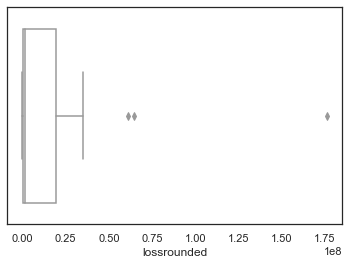

In [114]:
import seaborn as sns
ax = sns.boxplot(x=sorted_1["lossrounded"], color ="w")

In [129]:
print("\u03BB=",len(sorted_1["ln2"][0:len(sorted_1)-1])/ev,
      " \u03BC=", stat.mean(sorted_1["ln2"][0:len(sorted_1)-1]), "  \u03C3=", m.sqrt(stat.variance(sorted_1["ln2"][0:len(sorted_1)-1])))

oploss_montecarlo(len(sorted_1["ln2"][0:len(sorted_1)-1])/ev,
                  stat.mean(sorted_1["ln2"][0:len(sorted_1)-1]),
                  m.sqrt(stat.pvariance(sorted_1["ln2"][0:len(sorted_1)-1])),50000,100,100000)

λ= 2.3076923076923075  μ= 14.264721711391001   σ= 2.418831096648721


4384628682.396625

In [130]:
sortdown = sorted_1["ln2"][2:]
print("\u03BB=",len(sorted_1["ln2"][2:])/ev,
      " \u03BC=", stat.mean(sorted_1["ln2"][2:]), "  \u03C3=", m.sqrt(stat.variance(sorted_1["ln2"][2:])))

oploss_montecarlo(len(sorted_1["ln2"][2:])/ev,
                  stat.mean(sorted_1["ln2"][2:]),
                  m.sqrt(stat.pvariance(sorted_1["ln2"][2:])),
                  50000,100,100000)

λ= 2.230769230769231  μ= 14.746747325121905   σ= 2.244102748893725


3904639844.5257177

In [128]:
sortup = sorted_1["ln2"][0:len(sorted_1)-3]
print("\u03BB=",len(sorted_1["ln2"][0:len(sorted_1)-3])/ev,
      " \u03BC=", stat.mean(sorted_1["ln2"][0:len(sorted_1)-3]), "  \u03C3=", m.sqrt(stat.variance(sorted_1["ln2"][0:len(sorted_1)-3])))

oploss_montecarlo(len(sorted_1["ln2"][0:len(sorted_1)-3])/ev, 
                  stat.mean(sorted_1["ln2"][0:len(sorted_1)-3]), 
                  m.sqrt(stat.pvariance(sorted_1["ln2"][0:len(sorted_1)-3])),
                  50000,100,100000)

λ= 2.1538461538461537  μ= 14.001195933674417   σ= 2.2811863059470086


2039299506.431687

## Tőkebecslés csoportosítva:

Láthatóan az első csoport lambda értéke alcsony: λ= 2.5 így érdemes a csalásokat egy nagy kategóriába összevonni

In [9]:
full_capital_csop = 0

In [10]:
event_type_csop1 = df[df['group_1'].isin(['1','2'])]
print("\u03BB=",len(event_type_csop1)/ev,
      " \u03BC=", stat.mean(event_type_csop1["ln2"]), "  \u03C3=", m.sqrt(stat.pvariance(event_type_csop1["ln2"])))

type_1_2_cap=oploss_montecarlo(len(event_type_csop1)/ev, stat.mean(event_type_csop1["ln2"]), m.sqrt(stat.pvariance(event_type_csop1["ln2"])),50000,100,100000)
full_capital_csop += type_1_2_cap
type_1_2_cap

λ= 184.84615384615384  μ= 11.86686071450331   σ= 1.4613922130868684


181253372.178828

A csoportok összevonásával a becsült tőkekövetelmény összesítve csökken nagyságrendlieg 2 milliárd értékben

In [11]:
event_type_csop2 = df[df['group_1'].isin(['3','4'])]
print("\u03BB=",len(event_type_csop2)/ev,
      " \u03BC=", stat.mean(event_type_csop2["ln2"]), "  \u03C3=", m.sqrt(stat.pvariance(event_type_csop2["ln2"])))

type_3_4_cap=oploss_montecarlo(len(event_type_csop2)/ev, stat.mean(event_type_csop2["ln2"]), m.sqrt(stat.pvariance(event_type_csop2["ln2"])),50000,100,100000)
full_capital_csop += type_3_4_cap
type_3_4_cap

λ= 28.692307692307693  μ= 12.76709908323558   σ= 2.390201469699335


4941714440.545105

In [38]:
full_capital_csop += type_5_cap + type_6_cap + type_7_cap

In [39]:
full_capital_csop

7396849800.266216

## Szcenárióval kiegészített hibrid modell:

1.Csalás szcenárió: λ= 0.125  μ= 20.059390864021  σ= 0.3669234186377783

In [3]:
event_type_csop1 = df[df['group_1'].isin(['1','2'])]

In [20]:
lambda1= len(event_type_csop1)/ev
mu1 = stat.mean(event_type_csop1["ln2"])
sigma1 = m.sqrt(stat.pvariance(event_type_csop1["ln2"]))
correction = 50000

lambda2 = 0.125
mu2 = 20.059390864021
sigma2 = 0.3669234186377783

maincycle = 100
subcycle = 100000
subcycle_scenario = 25000

yearly_losses=[]
yearly_losses_scen =[]

for cycle in range(maincycle):
    
    operating_loss = []    
    lambdalist1 = np.random.poisson(lambda1, subcycle)
    lambdalist2 = np.random.poisson(lambda2, subcycle_scenario)
    
    for lambdas1 in lambdalist1:
        num = sum(np.random.lognormal(mu1, sigma1, lambdas1).tolist()) + lambdas1*correction
        operating_loss.append(num)
    yearly_losses.append(np.percentile(np.array(operating_loss),99.9))
    
    for lambdas2 in lambdalist2:
        num = sum(np.random.lognormal(mu2, sigma2, lambdas2).tolist())
        operating_loss.append(num)
    yearly_losses_scen.append(np.percentile(np.array(operating_loss),99.9))
    
capital1 = stat.mean(yearly_losses)
capital_scan = stat.mean(yearly_losses_scen)
print("Tőke értéke szcenárió nélkül:", round(capital1), "  A tőke értéke scenárióval: ", round(capital_scan))

Tőke értéke szcenárió nélkül: 181201827   A tőke értéke scenárióval:  1121812431


2 csoport szcenárió kulcs munkatársak távozása: 
λ= 0.25  μ= 17.608052194631  σ= 0.321966120194086

In [21]:
event_type_csop2 = df[df['group_1'].isin(['3','4'])]

In [22]:
lambda1= len(event_type_csop2)/ev
mu1 = stat.mean(event_type_csop2["ln2"])
sigma1 = m.sqrt(stat.pvariance(event_type_csop2["ln2"]))
correction = 50000

lambda2 = 0.25
mu2 = 17.608052194631
sigma2 = 0.321966120194086

maincycle = 100
subcycle = 100000
subcycle_scenario = 25000

yearly_losses=[]
yearly_losses_scen =[]

for cycle in range(maincycle):
    
    operating_loss = []    
    lambdalist1 = np.random.poisson(lambda1, subcycle)
    lambdalist2 = np.random.poisson(lambda2, subcycle_scenario)
    
    for lambdas1 in lambdalist1:
        num = sum(np.random.lognormal(mu1, sigma1, lambdas1).tolist()) + lambdas1*correction
        operating_loss.append(num)
    yearly_losses.append(np.percentile(np.array(operating_loss),99.9))
    
    for lambdas2 in lambdalist2:
        num = sum(np.random.lognormal(mu2, sigma2, lambdas2).tolist())
        operating_loss.append(num)
    yearly_losses_scen.append(np.percentile(np.array(operating_loss),99.9))
    
capital1 = stat.mean(yearly_losses)
capital_scan = stat.mean(yearly_losses_scen)
print("Tőke értéke szcenárió nélkül:", round(capital1), "  A tőke értéke scenárióval: ", round(capital_scan))

Tőke értéke szcenárió nélkül: 4880292132   A tőke értéke scenárióval:  4322810446


3.csoport szcenárió természeti katasztrófa: 
λ= 0.05  μ= 19.4153350593459  σ= 0.454089148768531

In [23]:
event_type_5 = df[df['group_1']== "5"]

In [24]:
lambda1= len(event_type_5)/ev
mu1 = stat.mean(event_type_5["ln2"])
sigma1 = m.sqrt(stat.pvariance(event_type_5["ln2"]))
correction = 50000

lambda2 = 0.05
mu2 = 19.4153350593459 
sigma2 = 0.454089148768531

maincycle = 100
subcycle = 100000
subcycle_scenario = 25000

yearly_losses=[]
yearly_losses_scen =[]

for cycle in range(maincycle):
    
    operating_loss = []    
    lambdalist1 = np.random.poisson(lambda1, subcycle)
    lambdalist2 = np.random.poisson(lambda2, subcycle_scenario)
    
    for lambdas1 in lambdalist1:
        num = sum(np.random.lognormal(mu1, sigma1, lambdas1).tolist()) + lambdas1*correction
        operating_loss.append(num)
    yearly_losses.append(np.percentile(np.array(operating_loss),99.9))
    
    for lambdas2 in lambdalist2:
        num = sum(np.random.lognormal(mu2, sigma2, lambdas2).tolist())
        operating_loss.append(num)
    yearly_losses_scen.append(np.percentile(np.array(operating_loss),99.9))
    
capital1 = stat.mean(yearly_losses)
capital_scan = stat.mean(yearly_losses_scen)
print("Tőke értéke szcenárió nélkül:", round(capital1), "  A tőke értéke scenárióval: ", round(capital_scan))

Tőke értéke szcenárió nélkül: 104688702   A tőke értéke scenárióval:  498697275


4.csoport szcenárió rendszerhiba: λ= 0.5 μ= 17.4921105641862 σ= 0.524788171131753

In [25]:
event_type_6 = df[df['group_1']== "6"]

In [26]:
lambda1= len(event_type_6)/ev
mu1 = stat.mean(event_type_6["ln2"])
sigma1 = m.sqrt(stat.pvariance(event_type_6["ln2"]))
correction = 50000

lambda2 = 0.5
mu2 = 17.4921105641862
sigma2 = 0.524788171131753

maincycle = 100
subcycle = 100000
subcycle_scenario = 25000

yearly_losses=[]
yearly_losses_scen =[]

for cycle in range(maincycle):
    
    operating_loss = []    
    lambdalist1 = np.random.poisson(lambda1, subcycle)
    lambdalist2 = np.random.poisson(lambda2, subcycle_scenario)
    
    for lambdas1 in lambdalist1:
        num = sum(np.random.lognormal(mu1, sigma1, lambdas1).tolist()) + lambdas1*correction
        operating_loss.append(num)
    yearly_losses.append(np.percentile(np.array(operating_loss),99.9))
    
    for lambdas2 in lambdalist2:
        num = sum(np.random.lognormal(mu2, sigma2, lambdas2).tolist())
        operating_loss.append(num)
    yearly_losses_scen.append(np.percentile(np.array(operating_loss),99.9))
    
capital1 = stat.mean(yearly_losses)
capital_scan = stat.mean(yearly_losses_scen)
print("Tőke értéke szcenárió nélkül:", round(capital1), "  A tőke értéke scenárióval: ", round(capital_scan))

Tőke értéke szcenárió nélkül: 5009672725   A tőke értéke scenárióval:  4422291239


5.csoport szcenárió szállítói nem teljesítés: λ= 0.33 μ= 17.5432136035585 σ= 0.415157218401507

In [27]:
event_type_7 = df[df['group_1']== "7"]

In [28]:
lambda1= len(event_type_7)/ev
mu1 = stat.mean(event_type_7["ln2"])
sigma1 = m.sqrt(stat.pvariance(event_type_7["ln2"]))
correction = 50000

lambda2 = 0.33
mu2 = 17.5432136035585
sigma2 = 0.415157218401507

maincycle = 100
subcycle = 100000
subcycle_scenario = 25000

yearly_losses=[]
yearly_losses_scen =[]

for cycle in range(maincycle):
    
    operating_loss = []    
    lambdalist1 = np.random.poisson(lambda1, subcycle)
    lambdalist2 = np.random.poisson(lambda2, subcycle_scenario)
    
    for lambdas1 in lambdalist1:
        num = sum(np.random.lognormal(mu1, sigma1, lambdas1).tolist()) + lambdas1*correction
        operating_loss.append(num)
    yearly_losses.append(np.percentile(np.array(operating_loss),99.9))
    
    for lambdas2 in lambdalist2:
        num = sum(np.random.lognormal(mu2, sigma2, lambdas2).tolist())
        operating_loss.append(num)
    yearly_losses_scen.append(np.percentile(np.array(operating_loss),99.9))
    
capital1 = stat.mean(yearly_losses)
capital_scan = stat.mean(yearly_losses_scen)
print("Tőke értéke szcenárió nélkül:", round(capital1), "  A tőke értéke scenárióval: ", round(capital_scan))

Tőke értéke szcenárió nélkül: 720679655   A tőke értéke scenárióval:  674608963
